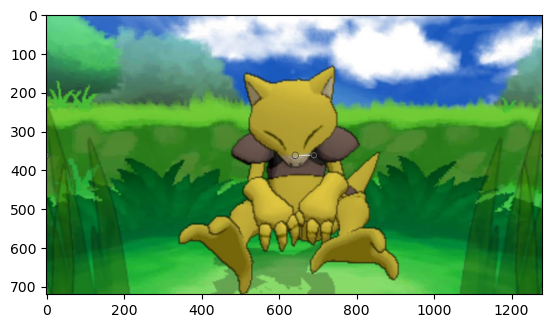

In [21]:
# Read .jpg
import imageio.v3 as iio
import matplotlib.pyplot as plt

image_relpath = 'data/pokemon/Abra/00000023.jpg'

img = iio.imread(image_relpath)

# 画像を表示
plt.imshow(img)
plt.show()

In [22]:
import sys
sys.path.append('RMBG-1.4')

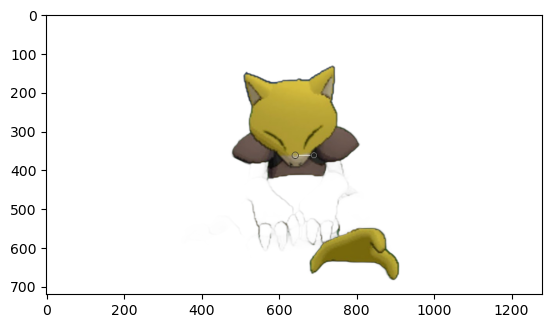

In [23]:
import matplotlib.pyplot as plt
from skimage import io
import torch, os
from PIL import Image
from briarmbg import BriaRMBG
from utilities import preprocess_image, postprocess_image

im_path = "data/pokemon/Abra/00000023.jpg"

net = BriaRMBG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BriaRMBG.from_pretrained("briaai/RMBG-1.4")
net.to(device)
net.eval()    

# prepare input
model_input_size = [1024,1024]
orig_im = io.imread(im_path)
orig_im_size = orig_im.shape[0:2]
image = preprocess_image(orig_im, model_input_size).to(device)

# inference 
result=net(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))
orig_image = Image.open(im_path)
no_bg_image.paste(orig_image, mask=pil_im)
out_path = im_path.replace("data/pokemon", "data/pokemon_no_bg").replace(".jpg", ".png")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
no_bg_image.save(out_path)

# 画像を表示
plt.imshow(no_bg_image)
plt.show()
